# Full MARS demo

This is the tutorial from the readme of MARS_Developer in Jupyter notebook form.

## 1. 📁 Create a new MARS Training Project

Your MARS project directory will contain all the files created during the process of training MARS detector and pose models on your data.

In addition to creating a project directory, `create_new_project` takes two optional arguments:
* Set `download_MARS_checkpoints=True` to download pre-trained MARS detection and pose models. If your dataset looks similar to MARS, initializing training from the pre-trained models should help decrease your training data requirements.
* Set `download_demo_data=True` to download a sample dataset, consisting of 2000 frames from videos in the [CRIM13 dataset](https://data.caltech.edu/records/1892), with accompanying manual annotations of animal pose collected via Amazon SageMaker. The sample dataset can also be previewed [here](https://drive.google.com/drive/u/0/folders/1J73k-RC1CyJQOjUdWr-75P3w_mfpRvXr).

In [7]:
from create_new_project import *
from os import path

location = '/home/klb807/MARS_project'
name = 'test'

create_new_project(location, name,
                   download_MARS_checkpoints=True,
                   download_demo_data=True)

# we will use this value for the rest of the notebook. 
project_path = path.join(location,name) 
# project_path = '' # use this if you already have a location in mind

A project named test already exists at this location. Please delete it or choose a different name.


Within your project folder is a file called `project_config.yaml`. This file contains many important features: keypoint and animal names, instructions for your annotation job, and names/data assignments for detection and pose models. Open this file in a text editor and fill in the fields as instructed in the comments.

## 2. ✍️ Collect a set of manually annotated animal poses
In this step, we will get some training data for our detector and pose estimator.

> If you set `download_demo_data=True` in step 1, **skip to step 2.3** to format your data for training.

> If you've already annotated some poses in DeepLabCut, copy the annotation csv to `my_project/annotation_data`, and the images you annotated to `my_project/annotation_data/raw_images`. Set `manifest_name` in `project_config.yaml` to the name of your csv.
>
> Then **skip to step 2.3** to format your data for training.

### 2.1 Extract video frames that you would like to annotate
First, we need to collect a set of video frames to annotate for animal pose. Copy these videos into `my_project/annotation_data/behavior_movies`.

Now, we'll use `extract_frames_to_label` to sample frames from these movies. It takes as input a project path, plus two optional arguments:
* `n_frames` the number of frames to sample for labeling (default is 1000)
* `to_skip` omits the first X frames from each video during sampling (default is 0)

If you already have frames on hand but haven't annotated them, copy those images to `my_project/annotation_data/raw_images` so they can be accessed during the labelling job and later during model training.



In [ ]:
from pose_annotation_tools.extract_frames_to_label import *

extract_frames_to_label(project_path, n_frames=100)

You should now have a folder `my_project/annotation_data/raw_images` of video frames.

### 2.2 Run a labeling job
Refer to [these instructions](https://github.com/neuroethology/MARS_Developer/blob/master/pose_annotation_tools/docs/readme_groundTruthSetup.md) to run a labeling job on Amazon SageMaker.

This job will produce a file called `output.manifest` which you should add to `my_project/annotation_data`. If you change the name of this manifest file, be sure to update the `manifest_name` field of `my_project/project_config.yaml` appropriately.

### 2.3 Post-process the manual pose annotations
This script carries out several steps to create "ground truth" keypoint locations by taking the median across AWS workers, correct for left/right flips of body part labels, and package your data for model-training. The processed annotation data will be added as a new file to `annotation_data`.

In [1]:
from pose_annotation_tools.annotation_postprocessing import *

annotation_postprocessing(project_path)

2023-09-28 14:04:44.647737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Processing manifest file...
2000
  frame 1000
Ground-truth keypoint locations extracted!
Generating black_top detection training files...


2023-09-28 14:04:52.902860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-28 14:04:52.903409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-28 14:04:52.939266: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-28 14:04:52.939285: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (FSMMJ0J8Y84): /proc/driver/nvidia/version does not exist
2023-09-28 14:04:52.940024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

done.
Generating white_top detection training files...
done.
Generating top pose training files...
done.
Generating black_top priors...


2023-09-28 14:05:08.265483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-28 14:05:08.282141: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2112000000 Hz
/home/klb807/miniconda3/envs/mars_dev_tf2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done.
Generating white_top priors...
done.


/home/klb807/miniconda3/envs/mars_dev_tf2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 2.4 Visualize some manual pose annotations

We'll next take a look at the inter-annotator variability in your pose labels, as this is a good predictor for how well MARS will perform. (If you annotated pose yourself you can skip this step.)

To look at annotations on an example frame, call `plot_frame`. It takes as input a project path and a number (specifying the image in your annotation dataset.) It also takes two optional plotting arguments:
* `markersize` the size of the keypoint makers (default is 8)
* `figsize` the width and height of the plot (default is [15,20])

The colored points are the raw annotation data. Points are colored by body part, and all points of a given marker shape come from the same worker. The black and white points are the medians across annotators. These medians are the "ground truth" that we'll use to train MARS.

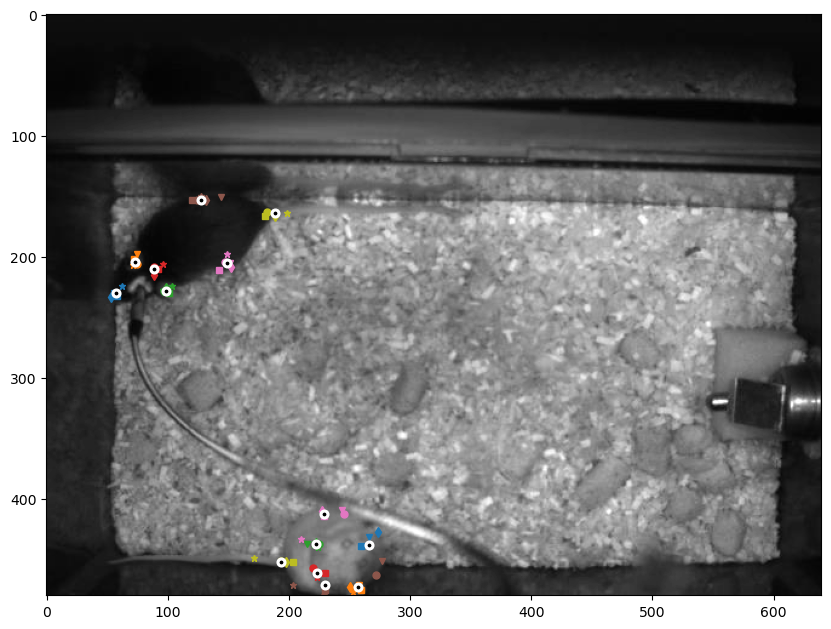

In [3]:
from pose_annotation_tools.evaluation import *

frame_num = 47  # the frame number to look at in your data

plot_frame(project_path,frame_num, markersize=5, figsize=[10,10])

To summarize worker performance, we'll look at the **Percent Correct Keypoints (PCK)**. This is the percentage of keypoints from individual workers that fall within a radius X of the "ground truth" worker median.

For each keypoint, we compute the distance from each worker's annotation to the median of the remaining workers, on each frame. We then plot cdfs of **median** (dashed line) worker-to-median distances for each frame, as well as a shaded area whose upper and lower bounds are the min and max worker-to-median distances, respectively.

The "all" plot takes the framewise average across keypoints, for each metric.

`plot_human_PCK` summarizes worker performance for your dataset. It takes four optional arguments:
* `animal_names` specifies which animals to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools data across animal types in your dataset.

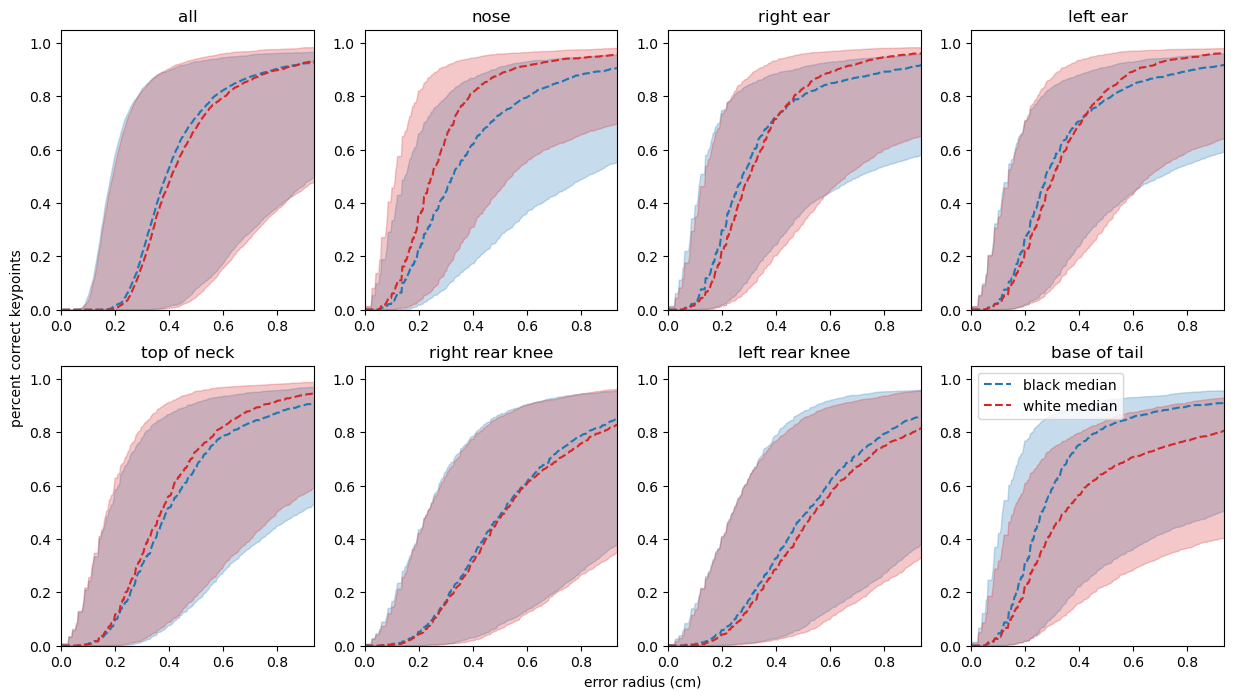

In [8]:
from pose_annotation_tools.evaluation import *

plot_human_PCK(project_path, combine_animals=False)

## 3. 🎯 Fine-tune the MARS detector to your data


### 3.1 Run the training code
`run_training` takes two optional arguments:
* `models` takes names of detectors to train, in case you only want to work on one detector at a time (MARS trains all detectors sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml` (300,000 by default). You can set this to a small number to confirm everything is working before launching your full training job.

If training is interrupted, it will resume from the most recent model checkpoint; MARS saves checkpoints every 30 minutes (adjust this in `my_project/detection/train_config.yaml`), and when training completes.

In [ ]:
from multibox_detection import train_detect

train_detect.run_training(project_path, max_training_steps=1500)

### 3.2 Visualize model performance and pick the best checkpoint
During training, we saved a model checkpoint every 30 minutes (by default). By testing model performance on a small held-out validation set, we can determine which checkpoint performs best, avoiding overfitting to the training set.

To see how far training has progressed, and whether performance might improve with more time, you can plot the validation loss (roughly, the error on the held-out validation set) with `plot_training_progress`. It takes four optional arguments:
* `detector_names` names of pose models to evaluate, as above.
* `figsize` width and height of the plot.
* `omitFirst` omits the first N training steps from plotting.
* `logTime` applies a log-scale to the x axis.

If the validation loss does not seem to have plateaued, your model performance may still improve with more training! Setting `logTime=True` and increasing the value of `omitFirst` can make it easier to see whether performance has plateaued.

In addition, we'll call `save_best_checkpoint` to identify the checkpoint with the greatest validation set performance, and extract it to a separate directory to be used for testing. It takes the optional argument:
* `detector_names` names of detection models to evaluate.

Even if performance hasn't plateaued, you can still proceed to **step 3.3** to evaluate the model on your test set. If you run additional training, be sure to call `save_best_checkpoint` again afterwards so your new best-performing checkpoint is used during testing.

In [9]:
from multibox_detection import evaluate_detection

# project_path = 'D:\my_project'
evaluate_detection.plot_training_progress(project_path, omitFirst=1000, logTime=False)
evaluate_detection.save_best_checkpoint(project_path)

ModuleNotFoundError: No module named 'tensorflow.contrib'

### 3.3 Evaluate model performance on a held-out test set

After picking the checkpoint that performs best on your validation set, we can evaluate that model's performance on the test set:


First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `detector_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [ ]:
from multibox_detection import evaluate_detection

performance = evaluate_detection.run_test(project_path)

First, let's look at ground truth and predicted bounding boxes for a sample frame. The `Multibox Detection` model makes multiple object detection predictions, each with an associated confidence value.

MARS keeps only the box with the highest confidence score, however when plotting we also show all predicted bounding boxes with a confidence of 0.75 or higher. To change this threshold, modify the optional `confidence_thr` argument to be some value between 0 (lowest) and 1 (highest).

In [ ]:
from multibox_detection import evaluate_detection

project_path = 'D:\my_project'
frame_num = 11

evaluate_detection.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10], confidence_thr=0.75)

Now let's get some summary statistics using the COCO API. The most common metric for evaluating detector performance is the **Intesection over Union (IoU)** - the ratio of the area of overlap between ground truth and predicted boxes, divided by the union of their areas- ie $(\textrm{ground truth} \cap \textrm{predicted})/(\textrm{ground truth} \cup \textrm{predicted})$.

We'll report the **mean Average Precision** and **mean Average Recall** (mAP and mAR) of the IoU, which are the average of Precision and Recall values computed over a range of thresholds on IoU values. This is a standard method for evaluating object detector performance; see the MARS manuscript for an explanation of this metric, or [this article](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3) for further reading.

In [ ]:
performance = evaluate_detection.coco_eval(project_path)

for model in performance.keys():
    print('Performance for ' + model + ':')
    performance[model].summarize()

Finally, we'll plot **PR Curves**, showing the Precision vs Recall of our detector for various confidence thresholds. Line color here indicates the minimum IoU required to be counted as a correct detection.

In [ ]:
from multibox_detection import evaluate_detection

project_path = 'D:\my_project'
evaluate_detection.pr_curve(project_path)

### 3.4 (Optional) test your detector on new videos

💡 If you are working with top-view mouse videos, it is possible that MARS's pose estimator will work for you out of the box now that you have a working detector. Skip to step 5 to try it out! If you're not happy with the performance, continue to step 4 where you'll be able to fine-tune the pose estimator.

## 4. 🐁 Fine-tune the MARS pose estimator to your data


### 4.1 Run the training code
Training the pose estimator is the same as training your detectors.

`run_training` again takes two optional arguments:
* `pose_model_names` takes names of pose models to train, in case you only want to work on one model at a time (MARS trains all models sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml`. You can set this to a small number to confirm everything is working before launching your full training job.

In [ ]:
from hourglass_pose import train_pose

project_path = 'D:\my_project'
train_pose.run_training(project_path)

### 4.2 Visualize model performance and extract the best checkpoint

As for the detector, we can check whether performance has plateaued and pick our best-performing version of the pose model.
You can plot the validation loss with `plot_training_progress`, which takes four optional arguments:
* `pose_model_names` names of pose models to evaluate, as above.
* `figsize` width and height of the plot.
* `omitFirst` omits the first N training steps from plotting.
* `logTime` applies a log-scale to the x axis.

And again, `save_best_checkpoint` will identify the pose model checkpoint with the greatest validation set performance, and extract it to a separate directory to be used for testing. It takes the optional argument:
* `pose_model_names` names of pose models to evaluate.

If the validation loss does not seem to have plateaued, your model performance may still improve with more training.

Even if performance hasn't plateaued, you can still proceed to **step 4.3** to evaluate your model on the test set. If you run additional training, be sure to call `save_best_checkpoint` again afterwards so your new best-performing checkpoint is used during testing.

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
evaluate_pose.plot_training_progress(project_path, omitFirst=1000, logTime=False)
evaluate_pose.save_best_checkpoint(project_path)

### 4.3 Evaluate model performance on a held-out test set

First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `pose_model_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
performance = evaluate_pose.run_test(project_path)

First, let's look at ground truth and predicted poses for a sample frame:

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
frame_num = 24

evaluate_pose.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10])

Now let's get some summary statistics using the COCO API. First, the mean Average Precision and mean Average Recall (mAP and mAR) of the Object Keypoint Similarity (OKS) -- see our [notebook on pose evaluation](hourglass_pose/pose_evaluation_on_test_tfrecords.ipynb) for a tutorial on what these metrics mean.

In [ ]:
performance = evaluate_pose.coco_eval(project_path)
performance['top']['all'].summarize()

By default, these values are computed using the "narrow" setting of the OKS, $\sigma = 0.025$. If you use the same keypoint names as MARS, you can also compute performance using keypoint-specific $\sigma$ values from the MARS pose datasets:

In [ ]:
performance = evaluate_pose.coco_eval(project_path, view='top')
performance['top']['all'].summarize()

Finally, let's compare our PCK distribution from our model to what we got from our human annotators. `plot_model_PCK` takes similar arguments `plot_human_PCK`:
* `pose_model_names` specifies which models to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools human annotation data across animal types in your dataset. Model performance plots are always pooled (to be fixed later.)

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
evaluate_pose.plot_model_PCK(project_path, combine_animals=True)

## 5. 🚀 Deploy your new detection and pose models

To use your trained models with the end-user version of MARS, we will export them as protobuf (`.pb`) files, which are saved to your main project folder.

`export` takes the optional arguments:
* `detector_names` specifies which detection models to save (defaults to all.)
* `pose_model_names` specifies which pose models to save (defaults to all.)


Copy the created files to your end-user version of MARS, in `mars_v1_8\models\detection` and `mars_v1_8\models\pose`. To run MARS using the new models, either modify the default settings in `mars_v1_8\config.yml`, or specify the model paths during runtime.

In [ ]:
import export_models

project_path = 'D:\my_project'
export_models.export(project_path)